In [32]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from pydantic import BaseModel
from typing import List, Annotated, TypedDict, Any
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# 它告诉 LangGraph 在每次 node 执行返回新的 messages 时
# 要自动把这些新消息 追加到原有的 state["messages"] 列表中 而不是替换掉它
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

**主要用于多轮对话生成更加合适的prompt**

In [19]:
class PromptInstructions(BaseModel):
    """首先定义一个prompt的结构 然后根据这个结构来生成prompt"""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]

# 定义state
class State(TypedDict):
    messages: Annotated[list, add_messages]


llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

llm_with_tool = llm.bind_tools([PromptInstructions])


# 每一轮对话中 都添加系统消息 防止模型忘记规则
def get_system_messages(msgs):
    return [SystemMessage(content=template)] + msgs

# info node
def info(state):
    msg = get_system_messages(state["messages"])
    response = llm_with_tool.invoke(msg)
    # 这里的response是AImseeage 内部包含tool_calls 和 content
    return {"messages": [response]}

**显然，一轮简单的对话并不能满足llm对于构建promt的要求，与之对应的，llm并没有调用tool**

In [9]:
state = {'messages': [HumanMessage(content='把我喜欢小八翻译成法语')]}
res = info(state)
res["messages"][0].tool_calls

[]

In [39]:
# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""

def get_prompt_msgs(msgs):
    # 收集对prompt有用的信息
    tool_calls = None
    other_msgs = []
    for msg in msgs:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            tool_calls = msg.tool_calls[0]['args']
        elif isinstance(msg, ToolMessage):
            continue
        # 收集在调用工具之后 用户输入的消息（可能）
        elif isinstance(msg, HumanMessage) and tool_calls:
            other_msgs.append(msg)
    return[SystemMessage(content=prompt_system.format(reqs=tool_calls))] + other_msgs

def prompt(state):
    msgs = get_prompt_msgs(state["messages"])
    response = llm.invoke(msgs)
    return {"messages": [response]}
        

In [ ]:
def get_state(state):
    msg = state['messages']
    if isinstance(msg[-1], AIMessage) and msg[-1].tool_calls:
        return "add_tool_message"
    # 安全机制?
    elif not isinstance(msg[-1], HumanMessage):
        return END
    else:
        return "info"
    # elif isinstance(msg[-1], HumanMessage):
    #     return "info"  # 用户输入了新消息，继续收集信息
    # else:
    #     return END  # 其他情况才结束（比如已经生成了最终的prompt）
    
def add_tool_message(state):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

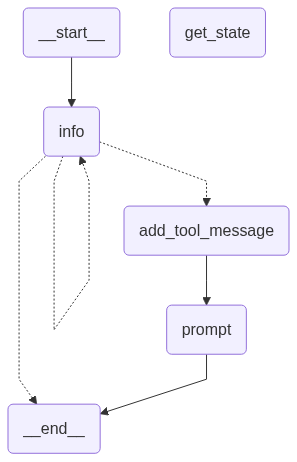

In [44]:
# 构造流程图
memeory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info)
workflow.add_node("prompt", prompt)
workflow.add_node("get_state", get_state)
workflow.add_node("add_tool_message", add_tool_message)

workflow.add_edge(START, "info")
workflow.add_conditional_edges("info", get_state, ['info', 'add_tool_message', END])
workflow.add_edge("add_tool_message", 'prompt')
workflow.add_edge('prompt', END)

app = workflow.compile(checkpointer=memeory)
app

In [45]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in app.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): 生成一个关于兰州大学的prompt
================================== Ai Message ==================================

请告诉我关于这个prompt的目标是什么？要传递哪些变量？有哪些约束条件？以及输出必须遵守的要求是什么？
User (q/Q to quit): q
AI: Byebye
